## Use Skimage filters to do pixel filtering/aggregation

In [1]:
import os, sys, copy, random, pickle
sys.path.append("../")
%load_ext autoreload
%autoreload 2
import cv2
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

from modules.Interproc import DBInterface
from modules.Interproc import GuiviewState
from modules.ControlTracking import TrackFactory
from modules.ControlDisplay import Display
from modules.ImgUtils import (filter_pixels_circle, crop_img)

from modules.AnalysisHelpers import ( multiPlot, colorCube,
         SubprocColorCube, subprocColorCube, buildConfusionData, 
         buildConfusionPlotData, buildRegionMarkers, confusionPlotByViews,
         confusionPlotByImage, PixelConfusionMatrix, cvtPlot,
         applyTracker, presetCubeViews, bytesToPic,
         croppedPic, bytesToPic2)
from modules.EvalHelpers import EvalTracker

### Build Data

In [2]:
#load in data
DATA_DIR = "../data/misc/books/iterthresha-vizdebug-1/"

db_name = "interprocGreen.db"
gsDb = DBInterface(os.path.join(DATA_DIR, db_name))
listGSg = [ pickle.loads(d[1]) for d in gsDb.selectAll()]

db_name = "interprocOrange.db"
gsDb = DBInterface(os.path.join(DATA_DIR, db_name))
listGSo = [ pickle.loads(d[1]) for d in gsDb.selectAll()]

print [_gs.frameCounter for _gs in listGSg]
print [_gs.frameCounter for _gs in listGSo]

col1, col2, col3, col4 = [], [], [], []

for _gs in listGSo:
    _gs.initDisplay()
    col1.append(_gs.getOrigFrame())
    col2.append(_gs.display.scoreFrame.copy())
    
for _gs in listGSg:
    _gs.initDisplay()
    col3.append(_gs.getOrigFrame())
    col4.append(_gs.display.scoreFrame.copy())
    
chart_data = [col1, col2, col3, col4]

[0, 22, 40, 47, 49, 78, 84, 125, 188, 380]
[0, 9, 78, 116, 136, 176, 195, 246, 307, 340]


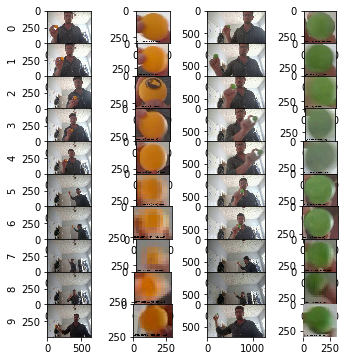

In [3]:
#concise view
multiPlot(chart_data, hspace = 0, wspace = 0, figsize = (6,6), input_transform_titles = range(len(chart_data[0])),
         bGrid=True)

In [4]:
# foi - FramesOfInterest
    # Target-object of: Large, Medium, Small 
    
framesList = [0, 380, 188]
foi = []

for _frameInd in framesList:
    
    _ind = [_gs.frameCounter for _gs in listGSg].index(_frameInd)
    
    foi.append(listGSg[_ind])

print len(foi)

3


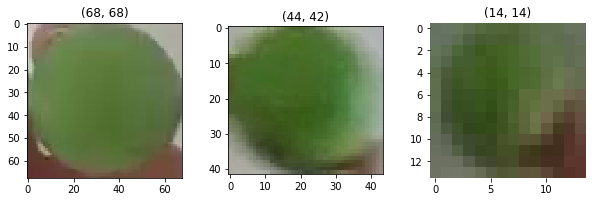

In [5]:
foi_imgs = []
foi_titles = []

for _gs in foi:
    
    #display actual pixel size score images
    x,y,dx,dy = _gs.displayInputScore['0']['data']

    foi_imgs.append( [_gs.getOrigFrame()[y:y+dy,x:x+dx,:]])
    foi_titles.append(str((dx,dy)))
    
multiPlot(foi_imgs, input_frame_titles = foi_titles)

In [6]:
# build images on which to experiment with transforms

x,y,dx,dy = foi[0].displayInputScore['0']['data']

img_large = foi[0].getOrigFrame()[y:y+dy,x:x+dx,:].copy()

x,y,dx,dy = foi[2].displayInputScore['0']['data']

img_small = foi[2].getOrigFrame()[y:y+dy,x:x+dx,:].copy()

img_small_grown = foi[2].display.scoreFrame.copy()   #320x320

### Explore Filters Visually 

In [7]:
from skimage.filters import sobel, gaussian, scharr, threshold_adaptive

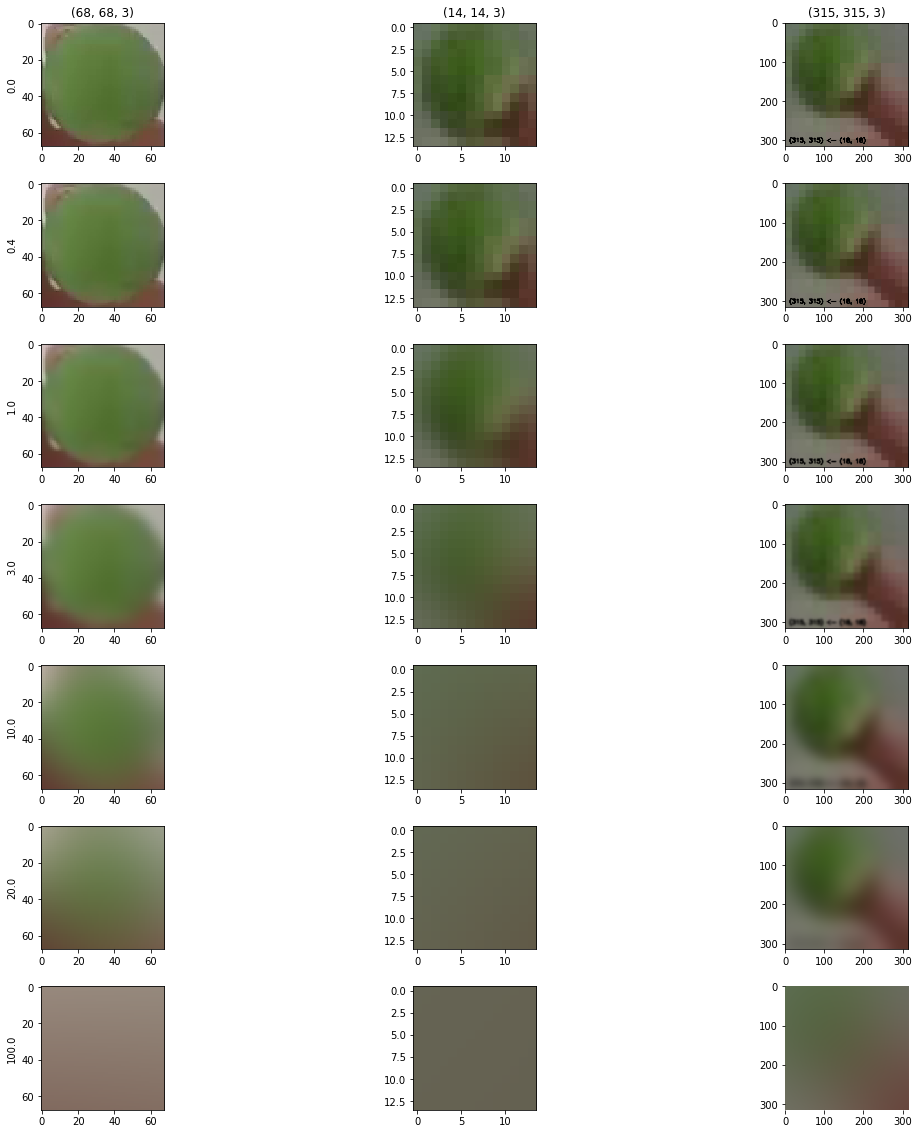

In [8]:
# comapre varying sigma levels on gaussian filter on 3 different type of images

sigma_levels = (0.0, 0.4, 1.0, 3.0, 10.0, 20.0, 100.0)

def varyFilter(img):
    
    img_data = []
    
    for _sigma in (0.0, 0.4, 1.0, 3.0, 10.0, 20.0, 100.0):
        
        img_t = gaussian(img, sigma = _sigma, multichannel=True, preserve_range=True,)

        img_data.append(np.array(img_t, dtype='uint8'))
        
    return img_data
        
        
vary_filter_imgs= [
     varyFilter(img_large)
    ,varyFilter(img_small)
    ,varyFilter(img_small_grown)
]

col_labels = [str(img_large.shape), str(img_small.shape), str(img_small_grown.shape)]
row_labels = map(str, sigma_levels)

multiPlot(vary_filter_imgs, 
          input_frame_titles = col_labels, 
          input_transform_titles= row_labels 
          ,figsize= (20,20), wspace = 0
         )

### First Analysis of Variation: {Large + Medium + Small} x {No-Filter, Sigma=10.0}

In [9]:
#foi_t - transform at Gaussian(sigma=10.0)

import copy
foi_t = copy.deepcopy(foi)

_sigma = 10.0

for _gs in foi_t:
    
    _origFrame = _gs.getOrigFrame()
    
    img_filter = gaussian(_origFrame, sigma = _sigma, multichannel=True, preserve_range=True,)

    img_t = np.array(img_filter, dtype='uint8')
    
    _gs.serial_origFrame = img_t.dumps()

### Explore difference in colorcube dispersion

In [11]:
#setup parameters

tracker = TrackFactory(on=True)
tracker.setInit(ballColor="green")
tracker.setAlgoEnum(1)
thresh1 = (tracker.getTrackParams()['thresh_lo']
           ,tracker.getTrackParams()['thresh_hi'])
print thresh1

views1 = presetCubeViews()
view1 = views1[0][1]
print view1

inputThresh = thresh1
figsize = (10,10)
bOutputScore = False

views1 = presetCubeViews()
view1 = views1[0][1]

((29, 86, 6), (64, 255, 255))
{'elevation': 95, 'azimuth': -81}


In [46]:
def chartData(listGS, N=1000):

    _ret = [] 
    
    for _gs in listGS:

        _pcm = buildConfusionData( _gs, [inputThresh]
                                        ,bOutputScore = bOutputScore)

        _plotData = buildConfusionPlotData(_pcm, N = N)

        _regionMarkers = buildRegionMarkers([inputThresh])

        _title = 'frame ' + str(_gs.frameCounter)

        _ret.append(
            bytesToPic2(
            colorCube( confData = _plotData
                  ,regionMarkers = _regionMarkers
                  ,viewPositionDefined = view1
                  ,bInitPosition = True
                  ,figsize = figsize
                  ,b_save=True
                 )
                )
            )
        
    return _ret

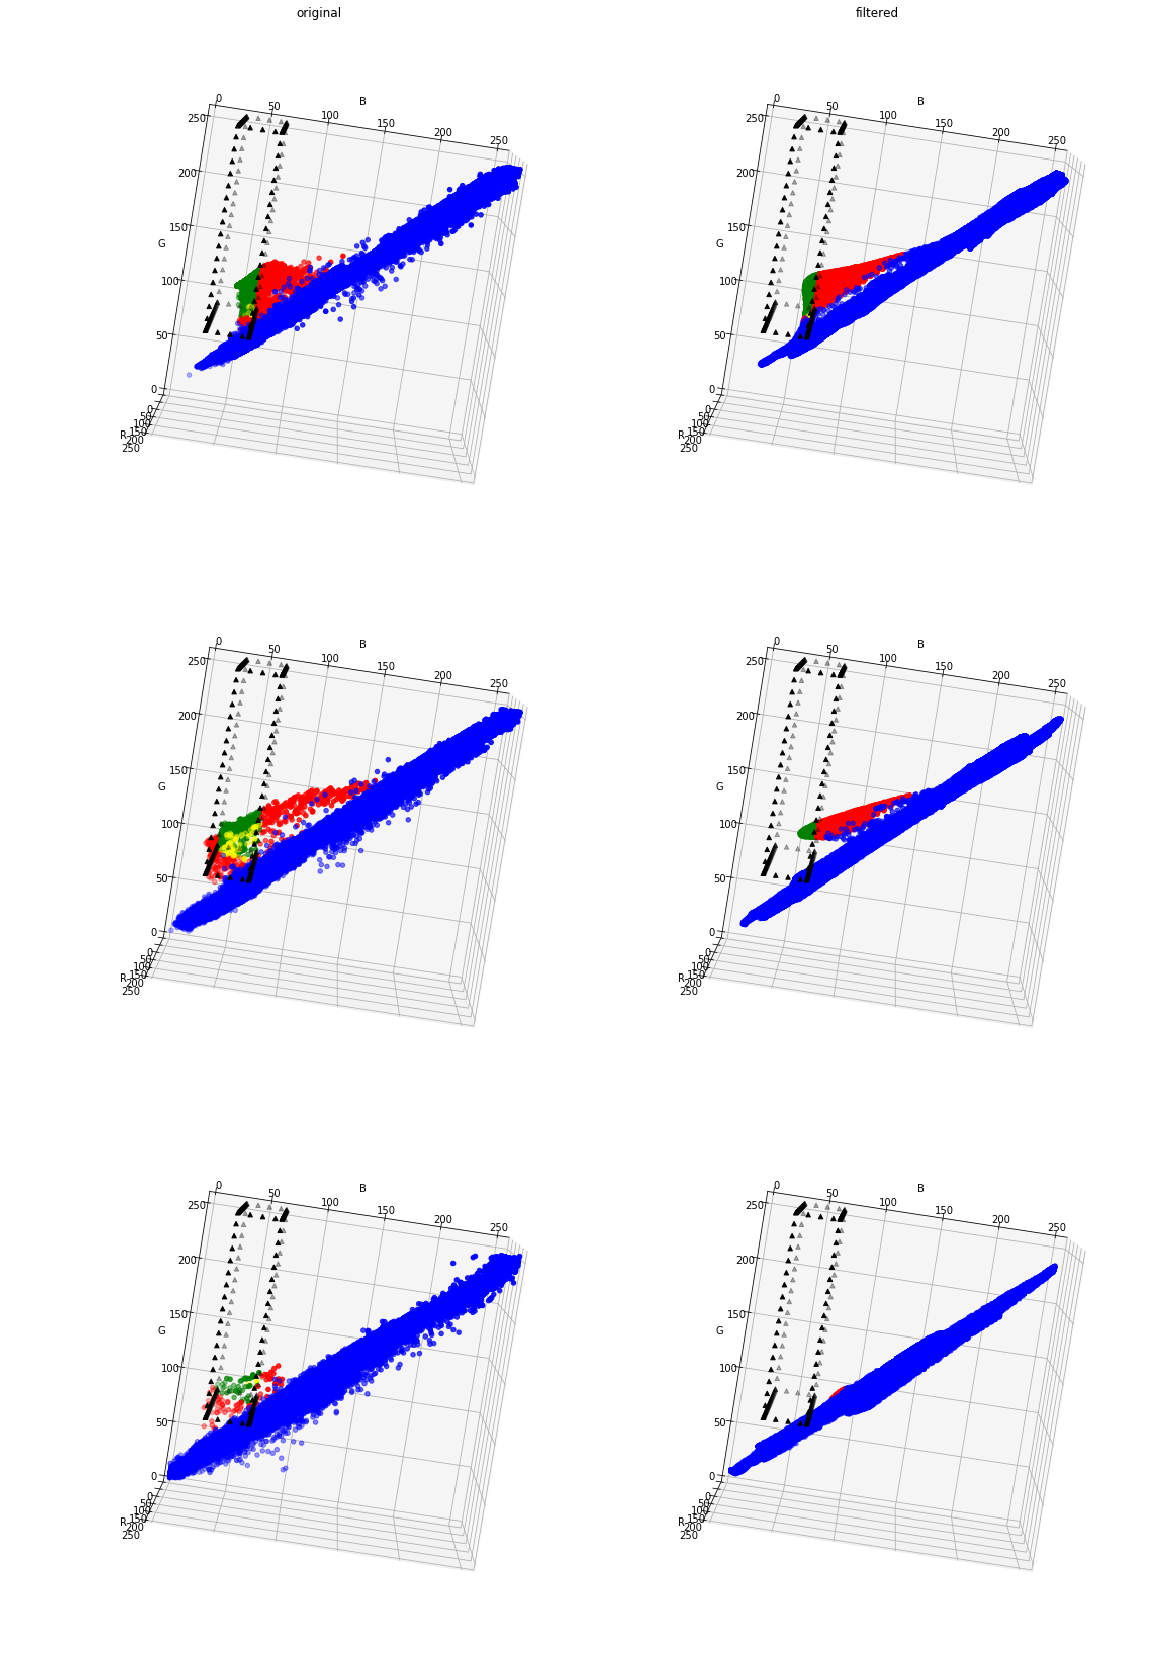

In [56]:
# compare the three frames 

chart_data = [
    chartData(foi, N=100000)
    ,chartData(foi_t, N=100000)
]

# Large + Medium frames (shape > sigma): become better segmented
# Small frame: (shape = sigma): become less segmented
multiPlot(chart_data, figsize = (20,30), wspace = 0, hspace = 0,  bGrid = False, 
          input_frame_titles = ["original","filtered"]
         ,input_transform_titles = [str(_gs.frameCounter) for _gs in foi]
         )

In [14]:
#Numerical Proof: for Small Target Frame: with strong filtering we lose all TruePositives
_gs = foi_t[2]
_pcm = buildConfusionData( _gs, [inputThresh]
                                ,bOutputScore = bOutputScore)
_pcm.displayVals()

                                         True          False
                        921600            149         921451
       Positive              0              0              0
       Negative         921600         921451            149


### Second Analysis: Progressive increase on Sigma: {0, 0.4, 1.0, 2.0, 10.0, 100.0} x {Large, Small}

In [33]:
#foi_t - transform at Gaussian(sigma=10.0)

import copy
foi_s_large = copy.deepcopy(foi[0])
foi_s_small = copy.deepcopy(foi[2])

sigma_levels = (0.0, 0.4, 1.0, 2.0, 10.0, 100.0)

foi_s_large = [ copy.deepcopy(foi_s_large) for _ in range(len(sigma_levels))]
foi_s_small = [ copy.deepcopy(foi_s_small) for _ in range(len(sigma_levels))]

for _gs in (foi_s_large, foi_s_small):
    
    for i, _sigma in enumerate(sigma_levels):
        
        _origFrame = _gs[i].getOrigFrame()

        img_filter = gaussian(_origFrame, sigma = _sigma, multichannel=True, preserve_range=True,)

        img_t = np.array(img_filter, dtype='uint8')

        _gs[i].serial_origFrame = img_t.dumps()

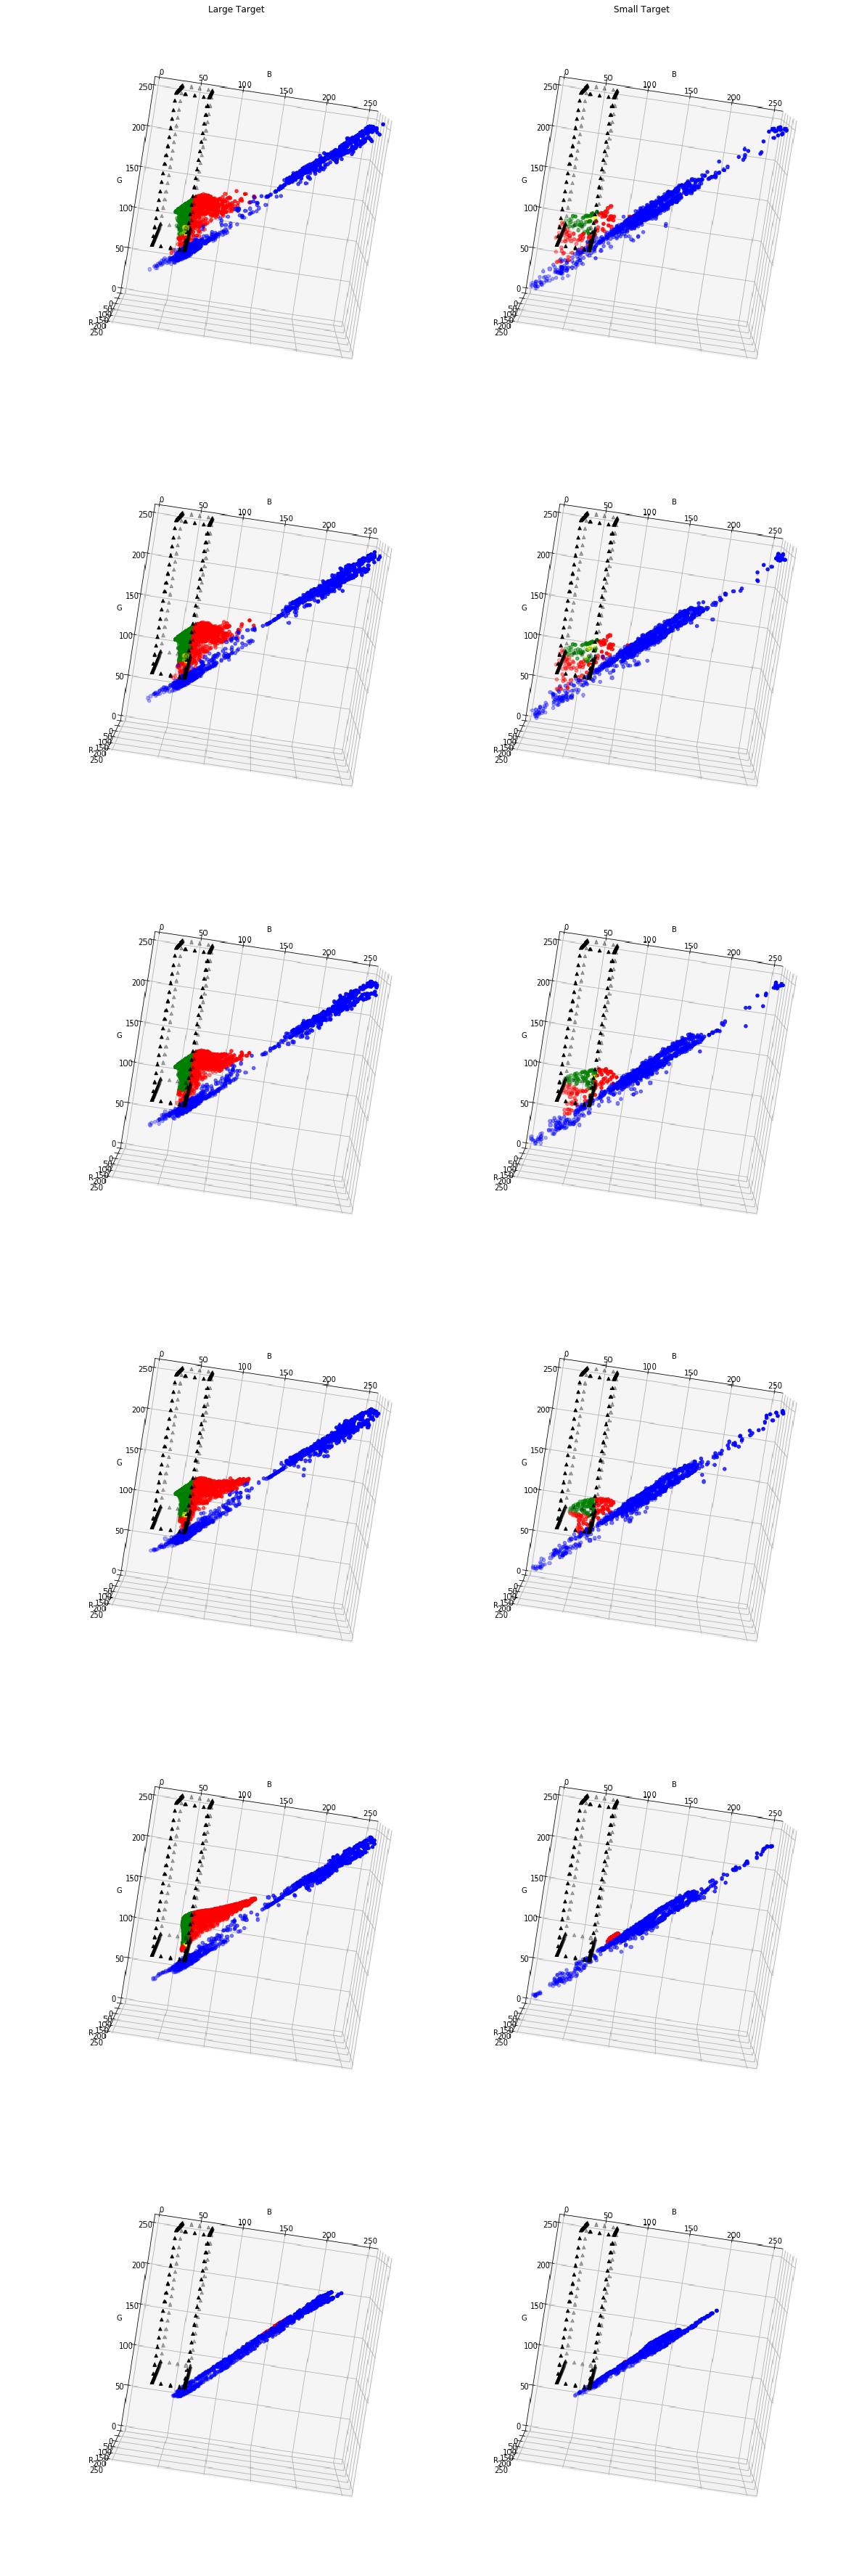

In [53]:
chart_data = [
    chartData(foi_s_large)
    ,chartData(foi_s_small)
]

multiPlot(chart_data, figsize = (20,65), wspace = 0, hspace = 0,  bGrid = False, 
          input_frame_titles = ["Large Target","Small Target"]
         ,input_transform_titles = [str(_sigma) for _sigma in sigma_levels]
         )

# multiPlot(chart_data)